In [30]:

import os
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from fredapi import Fred
from dataset import Dataset
import gtab
#sci-kit imports
from sklearn.linear_model import LinearRegression, Ridge
from sktime.performance_metrics.forecasting import mean_squared_percentage_error
from sklearn.svm import LinearSVR
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.pipeline
from pipeline import Pipeline
from visualizations import Visualizer
np.random.seed(42)

In [45]:
pipeline = Pipeline(crypto_tick = "ltc", returns= True)
pipeline.preprocess_dataset()
pipeline.set_beginning(start_date = "2015-07-01")
pipeline.data.iloc[:,:-1] = np.log(pipeline.data.iloc[:, :-1]).diff()
pipeline.shift_target()

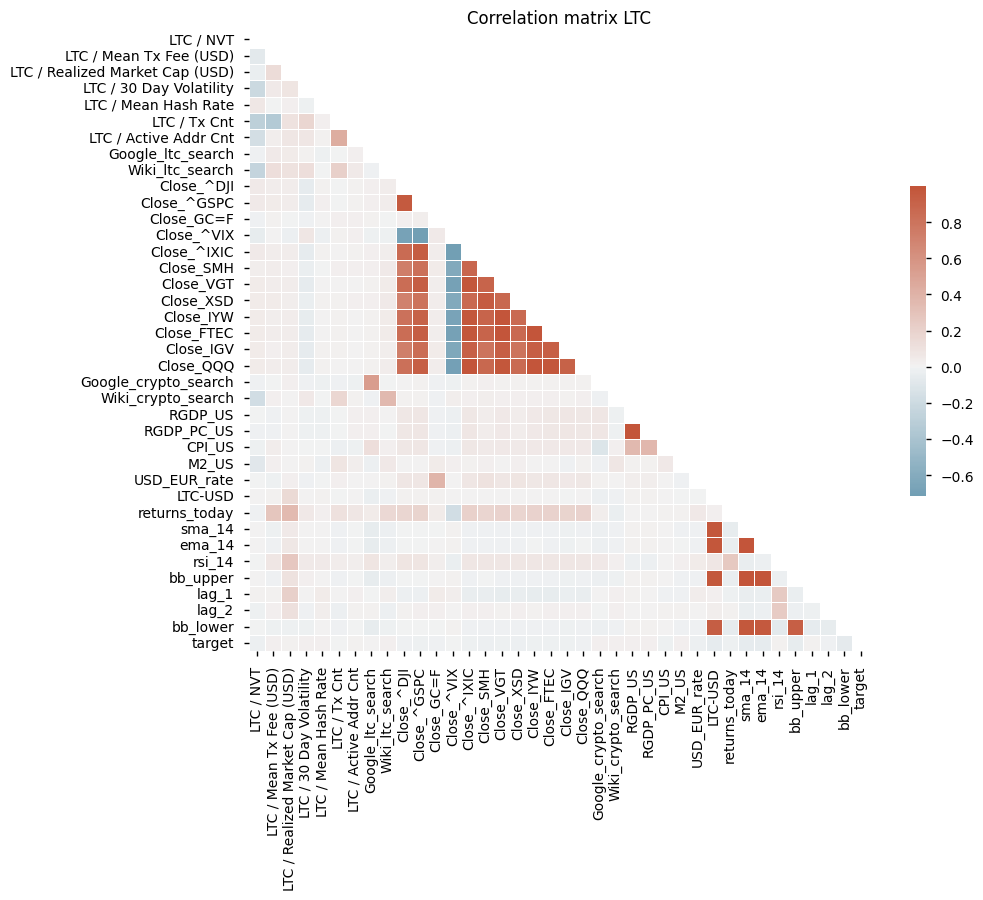

In [46]:
vis = Visualizer()
vis.draw_corr_cov_heatmap(pipeline.data_1d_shift)
plt.title(f"Correlation matrix {pipeline.tick.upper()}")
plt.tight_layout()
plt.savefig('Corr_ltc_logdiff.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
pipeline.shift_target()
pipe = Pipeline.assembly_pipeline(estimator = Ridge(), dim_reducer = None)

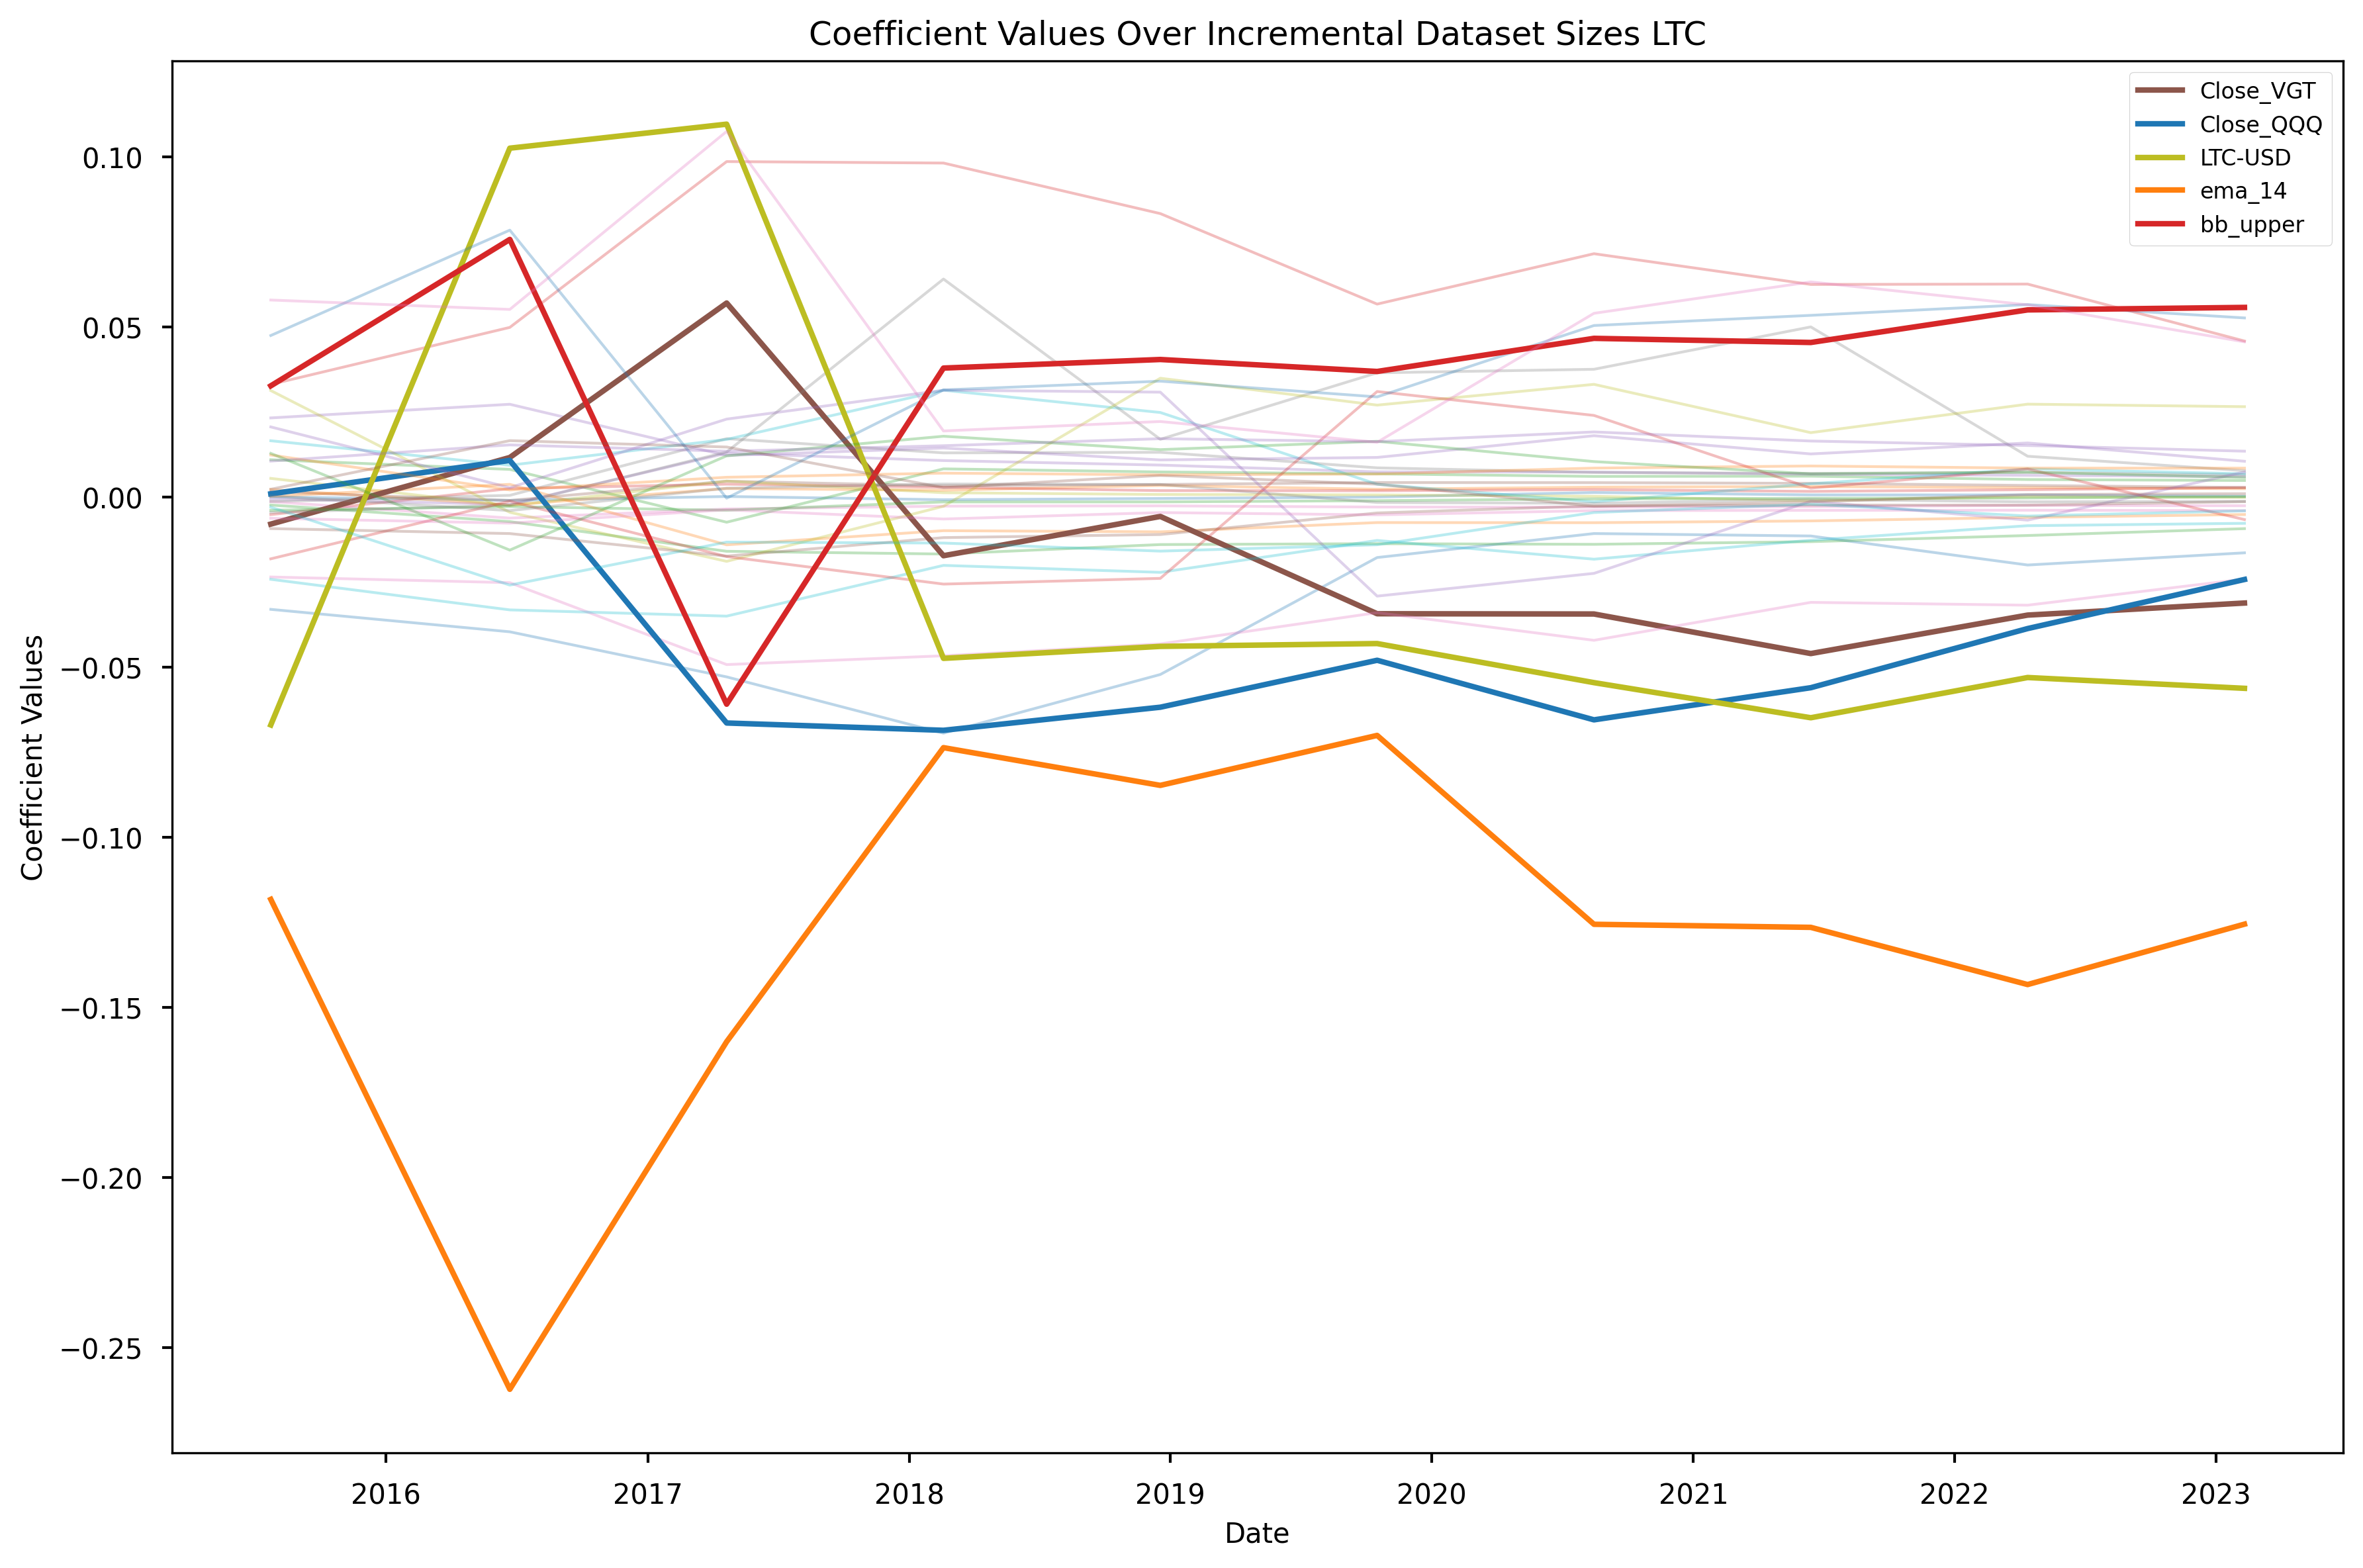

In [28]:
coefs_incremental = []
data_size = len(pipeline.data_10d_shift)
increment = data_size // 10
STYLE = "seaborn-v0_8-notebook"
plt.style.use(STYLE)

# Create a figure with specified DPI and size
plt.figure(figsize=(12, 8), dpi=300)

for i in range(1, 11):
    subset = pipeline.data_10d_shift.iloc[:i * increment]
    pipe.fit(subset.iloc[:, :-1], subset.iloc[:, -1])
    coefs_incremental.append(pipe.named_steps['estimator'].coef_)

variances = np.var(coefs_incremental, axis=0)
top_5_indices = np.argsort(variances)[-5:]

dates = pipeline.data_10d_shift.index[:increment * 10:increment]
for idx, column in enumerate(pipeline.data_10d_shift.columns[:-1]):
    if idx in top_5_indices:
        plt.plot(dates, [coef[idx] for coef in coefs_incremental], label=column, linewidth=2)
    else:
        plt.plot(dates, [coef[idx] for coef in coefs_incremental], alpha=0.3, linewidth=1)

plt.title("Coefficient Values Over Incremental Dataset Sizes LTC", fontsize=12)
plt.xlabel("Date", fontsize=10)
plt.ylabel("Coefficient Values", fontsize=10)
plt.legend(loc="best", fontsize=8)
plt.tight_layout()
plt.savefig('coefficient_values_incremental_ltc.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

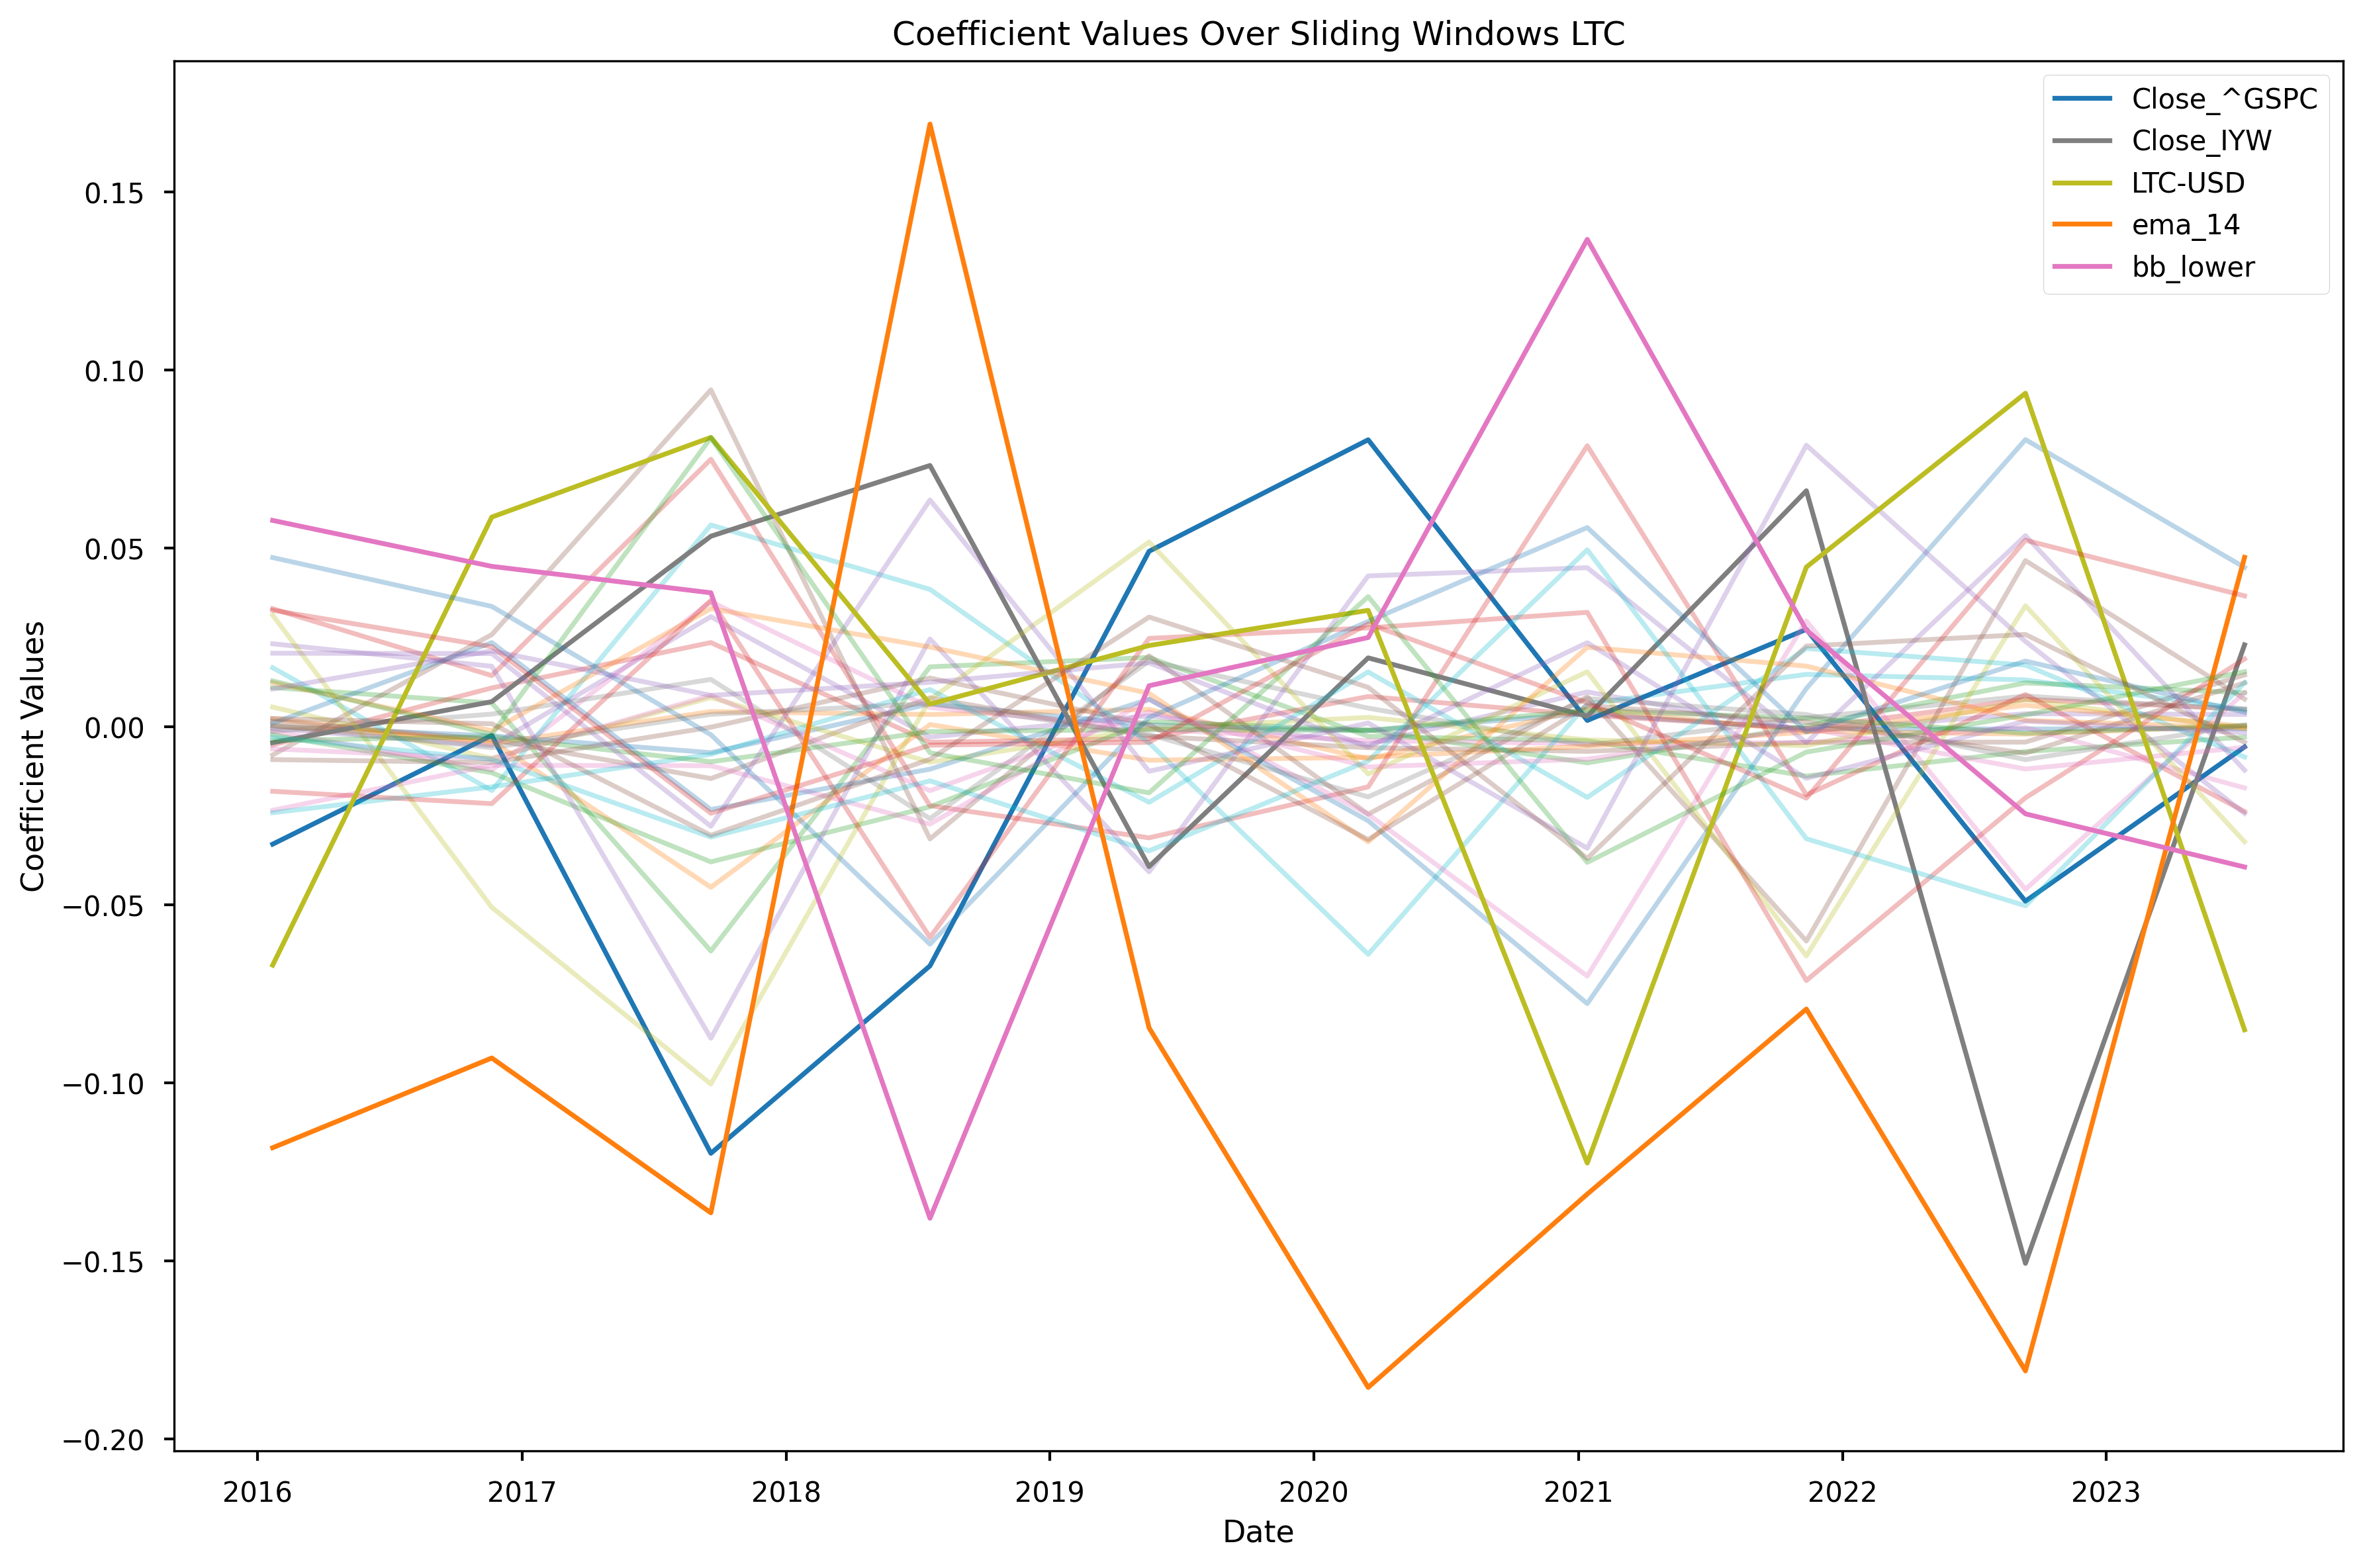

In [29]:
window_size = data_size // 10  # Size of the sliding window
step_size = window_size
coefs_sliding = []
STYLE = "seaborn-v0_8-notebook"
plt.style.use(STYLE)
plt.figure(figsize=(12, 8), dpi=300)
for i in range(10):  # Create 10 windows
    start_idx = i * step_size
    end_idx = start_idx + window_size
    if end_idx > data_size:
        break
        
    # Get the window subset
    subset = pipeline.data_10d_shift.iloc[start_idx:end_idx]
    
    # Fit the pipeline with the subset
    pipe.fit(subset.iloc[:, :-1], subset.iloc[:, -1])
    
    # Save the coefficients
    coefs_sliding.append(pipe.named_steps['estimator'].coef_)

# Calculate variance for each coefficient
variances = np.var(coefs_sliding, axis=0)
top_5_indices = np.argsort(variances)[-5:]  # Get indices of top 5 coefficients with highest variance

# Plot the coefficients
dates = pipeline.data_10d_shift.index[window_size//2::step_size][:len(coefs_sliding)]  # Get the center dates for each window
for idx, column in enumerate(pipeline.data_10d_shift.columns[:-1]):
    if idx in top_5_indices:
        plt.plot(dates, [coef[idx] for coef in coefs_sliding], label=column)
    else:
        plt.plot(dates, [coef[idx] for coef in coefs_sliding], alpha=0.3)  # Dim the other lines

plt.title("Coefficient Values Over Sliding Windows LTC")
plt.xlabel("Date")
plt.ylabel("Coefficient Values")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig('coefficient_values_sliding_ltc.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
pipeline.data_10d_shift.shape

(1948, 41)

In [ ]:
import pandas as pd
pd.read_csv("./../Data/ltc.csv")

In [ ]:
from dataset import BitcoinDataset, EthereumDataset, LitecoinDataset
eth_dataset = LitecoinDataset()

In [ ]:
eth_dataset.save_data_to_csv()

In [ ]:
import random
import gtab
import time

# Only need to run this once, the rest of requests will use the same session.


In [ ]:
import pandas as pd
data_btc = pd.read_csv("./../Data/BTC.tsv",encoding="utf-16-le", sep = "	")
data_rest = pd.read_csv("./../Data/ETH-LTC.tsv",encoding="utf-16-le", sep = "	")
data_btc["Time"] = pd.to_datetime(data_btc["Time"])
data_btc.set_index("Time", inplace=True)
data_btc.index.name = None
data_rest["Time"] = pd.to_datetime(data_rest["Time"])
data_rest.set_index("Time", inplace=True)
data_rest.index.name = None
data = pd.merge(data_btc, data_rest, left_index=True, right_index=True, how="outer")
data.to_csv("./../Data/coinmetrics_data_new.csv")

In [ ]:
#controling whether tensorflow does recognize my GPU
tf.config.get_visible_devices("GPU")

In [ ]:
data = Dataset.get_btc_data()

In [ ]:
data = data.loc["2014-9-17":]

In [ ]:
data

In [ ]:
{col: [data[col].isnull().sum(), f'% {np.round(np.mean(data[col].isnull()*100), 3)}'
      ] for col in data.columns if data[col].isnull().any()}

In [ ]:

data['Wiki_crypto_search'] = data['Wiki_crypto_search'].fillna(0)
data['Wiki_btc_search'] = data['Wiki_btc_search'].fillna(0)
#to be changed
data["BTC / Capitalization, market, estimated supply, USD"] = data["BTC / Capitalization, market, estimated supply, USD"].fillna(0)

In [ ]:
data

In [ ]:
data[['Close_^DJI','Close_^GSPC','Close_GC=F','Close_^VIX','Close_^IXIC',
    'Close_SMH','Close_VGT','Close_XSD','Close_IYW','Close_FTEC','Close_IGV',
    'Close_QQQ','USD_EUR_rate']] = data[['Close_^DJI','Close_^GSPC','Close_GC=F','Close_^VIX','Close_^IXIC',
    'Close_SMH','Close_VGT','Close_XSD','Close_IYW','Close_FTEC','Close_IGV',
    'Close_QQQ','USD_EUR_rate']].ffill()
data["BTC-USD"] = data["BTC-USD"].shift(-10)
data = data.dropna()

In [ ]:
data.head(20)

In [ ]:
from scikeras.wrappers import KerasRegressor
pipe = KerasRegressor(build_fn = Pipeline.assembly_lstm,
            verbose=1, random_state = 42, shuffle = False, batch_size = 50,epochs=50, input_shape=(1, 52),
                    units = 150)

x,y = Pipeline.create_lstm_input(data.copy(), data.copy().iloc[:,-1], 1)
train_data, test_data, train_target, test_target = Pipeline.split_train_test([x,y], pandas = False)
scaler = sklearn.preprocessing.RobustScaler(unit_variance=True)
minimax = sklearn.preprocessing.MinMaxScaler((0,1))
# train_target = np.squeeze(minimax.fit_transform(train_target.reshape(-1, 1)))
# test_target = np.squeeze(minimax.transform(test_target.reshape(-1, 1)))
train_data = scaler.fit_transform(train_data.reshape((-1,52))).reshape(-1,1,52)
test_data = scaler.transform(test_data.reshape((-1,52))).reshape(-1,1,52)
#model = pipe.fit(train_data, train_target,callbacks = [tb_callback])

In [ ]:
train_data.shape

In [ ]:
train_target

In [ ]:
model = pipe.fit(train_data, train_target)

In [ ]:
mean_squared_percentage_error(train_target, pipe.predict(train_data),square_root=True)

In [ ]:
plt.plot(np.concatenate([pipe.predict(train_data),pipe.predict(test_data)]),linewidth=1)
plt.plot(np.concatenate([train_target,test_target]),linewidth=1)

In [ ]:
data.columns

In [ ]:
data

In [ ]:
fig = Visualizer.draw_missing_data(data)
fig.show()

In [ ]:
""" data.drop(["BTC / Capitalization, market, free float, USD",
           "BTC / Capitalization, realized, USD",
           "BTC / Capitalization, market, current supply, USD",
           "BTC / Capitalization, market, estimated supply, USD"], axis = 1, inplace=True) """

In [ ]:
train_data, validation_data, train_target, validation_target = sklearn.model_selection.train_test_split(data.iloc[:, :-1], data.iloc[:, -1], test_size = 0.1, random_state=42, shuffle=False)
scaler = sklearn.preprocessing.RobustScaler()
pipe = sklearn.pipeline.Pipeline([("scaler",scaler),("estimator",LinearSVR())])
from pipeline import Pipeline
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(), dim_reducer = None)
parameter_grid = {"scaler__unit_variance":[True,False],"estimator__C": [0.2,0.5,0.7,1,3,5,10,20,30]}
split = sklearn.model_selection.TimeSeriesSplit(n_splits=3)
model = sklearn.model_selection.GridSearchCV(pipe, parameter_grid,cv=split, scoring = 'neg_root_mean_squared_error', verbose = 4, n_jobs=-1).fit(train_data,train_target)
print(model.best_params_)
print(model.best_estimator_)
print(model.best_score_)

In [ ]:
model

In [ ]:
[(el[0].shape, el[1].shape) for el in split.split(train_data)]

In [ ]:
validation_data

In [ ]:
predictions = model.predict(validation_data)

In [ ]:
train_data

In [ ]:
len(predictions)

In [ ]:
validation_target.iloc[10:]

In [ ]:
validation_target.shift(10).dropna()

In [ ]:
from sktime.performance_metrics.forecasting import mean_squared_percentage_error
mean_squared_percentage_error(validation_target.shift(10).dropna(),validation_target.iloc[10:])

In [ ]:
plt.plot(validation_target.shift(10).dropna())
plt.plot(validation_target.iloc[10:])

In [ ]:
y_pred = pd.Series(predictions, index=validation_data.index)
train_pred = pd.Series(model.predict(train_data), index = train_data.index)

In [ ]:
visualizer = Visualizer()
fig = visualizer.draw_prediction_full(train_target, train_pred, validation_target, y_pred, 10)
fig.show()

In [ ]:
fig = visualizer.draw_prediction_test(validation_target, y_pred, 10)
fig.show()